In [43]:
import pandas as pd
import sqlite3
import zipfile
import numpy as np
from  pandasql import sqldf
from matplotlib import pyplot as plt


# Master Data Filtering and Cleaning

After identifying the data sets needed by all members of our team, we first cleaned the `tn.movie_budgets.csv.gz` by converting it to a Pandas DataFrame and stripping all punctuation from the columns related to finance. All items in these columns were then converted to . A new column was created in the DataFrame called "ROI" in which the return on investment was calculated using the following equation:

##### 100 * worldwide_gross - budget)/(worldwide_gross)

Yet another column was then added named "start_year" in order to help with joining the DataFrame in later steps. Finally, all rows where worldwide gross was zero were eliminated from the data.

In [44]:
tn_movie = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
tn_movie

#Remove all $ and commas for domestic gross, worldwide gross, and production budget

tn_movie["production_budget"]=tn_movie["production_budget"].map(lambda x: int(x.replace(',', '').replace('$', '')))
tn_movie["domestic_gross"]=tn_movie["domestic_gross"].map(lambda x: int(x.replace(',', '').replace('$', '')))
tn_movie["worldwide_gross"]=tn_movie["worldwide_gross"].map(lambda x: int(x.replace(',', '').replace('$', '')))


#Add ROI column - defined as (worldwide_gross - budget)/(worldwide_gross)
tn_movie["ROI"]= 100*(tn_movie["worldwide_gross"]- tn_movie["production_budget"])/    \
         tn_movie["production_budget"]

#Add Profit column
tn_movie["profit"]= (tn_movie["worldwide_gross"]- tn_movie["production_budget"])

#Add start year as int column

tn_movie["start_year"] = tn_movie["release_date"].map(lambda x: int(x[-4:]))

#Eliminate any worldwide gross columns that = 0

tn_movie = tn_movie [tn_movie .worldwide_gross != 0]

# tn_movie

Next a connection was established to the unzipped `im.db` file and a curser was created. The master data set required us to select all columns from the `movie_basics` table which were put into a new DataFrame. This DataFrame was then joined with the `tn_movie` DataFrame above and joined into a new DataFrame named `imdb_basics`.

In [45]:

conn = sqlite3.connect('zippedData/im.db')
cur= conn.cursor()
# cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""").fetchall()

In [46]:
q1 = """SELECT * FROM movie_basics ;"""
dfzip=pd.read_sql(q1, conn)
imdb_basics = pd.merge(left= dfzip ,right = tn_movie, left_on=["start_year","primary_title"], \
                       right_on=["start_year","movie"], \
                          how = 'inner')
# imdb_basics

To ensure there are multiple rows referring to the same film, duplicates with matching name and start year were dropped.

In [47]:
imdb_basics_duplicate = imdb_basics[imdb_basics['primary_title'].duplicated()][imdb_basics['start_year'].duplicated()]
imdb_basics = imdb_basics.drop(imdb_basics_duplicate.index)

<ipython-input-47-60f4e1a2431a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imdb_basics_duplicate = imdb_basics[imdb_basics['primary_title'].duplicated()][imdb_basics['start_year'].duplicated()]


# Goal 1 - Genre and Profitability

## Finding the Unique List of Genres

The first step was to drop rows with undefined genres from the dataframe 'imdb_basics' before we categorized each film by genre.

In [48]:
imdb_basics=imdb_basics.dropna(subset=['genres'])
#dropped the rows with undefined genres

In [49]:
imdb_basics[["primary_title","genres","ROI"]]

,primary_title,genres,ROI
0,Foodfight!,"Action,Animation,Comedy",-99.836209
1,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",106.440860
2,A Walk Among the Tombstones,"Action,Crime,Drama",121.816382
3,Jurassic World,"Action,Adventure,Sci-Fi",666.909239
4,The Rum Diary,"Comedy,Drama",-52.122818
...,...,...,...
1417,The Mule,"Crime,Drama,Thriller",241.715352
1418,Teefa in Trouble,"Action,Comedy,Crime",-93.412933
1419,Happy Death Day 2U,"Drama,Horror,Mystery",613.105500
1420,Fahrenheit 11/9,Documentary,33.074300


In [50]:
imdb_basics['genres'][0]

'Action,Animation,Comedy'

As shown above, many films are categorized under more than one genres. For example, `'Foodfight!'` is in three genres, which are `'Action, Animation, Comedy'`.

One major consideration we had to make was whether we should retain the combination of genres as a distinct category or include it into each of the genres. In other words, should we make a new genre called `'Action, Animation, Comedy'` or place `'Foodfight!'` into the `'Action'` genre, `'Animation'` genre, and `'Comedy'` genre?

The former would offer more nuanced data as to which specific combination of genres would be the most profitable, yet the data frame would then account for too many genres, making it confusing and inaccessible to the audience.

Thus, we've decided to place films into each of genres separately.

The second step was to make a list of unique genres to see how many distinct genres there are.

In [51]:
list_of_unique_values =' '.join(imdb_basics.genres.unique())
list_of_unique_values = list_of_unique_values.replace(' ',',')
list_of_unique_genres = list_of_unique_values.split(",")
list_of_unique_genres = sorted(list(set(list_of_unique_genres)))
list_of_unique_genres

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

Next, `imdb_basics` dataframe was translated into variables, which categorizes films by unique genres. Since values under the `'genres'` column in imdb_basics are strings, inputting the genre name into the `.str.contains()` method will filter data by genre.

In [52]:
imdb_action = imdb_basics[imdb_basics['genres'].str.contains('Action')]
imdb_adventure = imdb_basics[imdb_basics['genres'].str.contains('Adventure')]
imdb_animation = imdb_basics[imdb_basics['genres'].str.contains('Animation')]
imdb_biography = imdb_basics[imdb_basics['genres'].str.contains('Biography')]
imdb_comedy = imdb_basics[imdb_basics['genres'].str.contains('Comedy')]
imdb_crime = imdb_basics[imdb_basics['genres'].str.contains('Crime')]
imdb_documentary = imdb_basics[imdb_basics['genres'].str.contains('Documentary')]
imdb_drama = imdb_basics[imdb_basics['genres'].str.contains('Drama')]
imdb_family = imdb_basics[imdb_basics['genres'].str.contains('Family')]
imdb_fantasy = imdb_basics[imdb_basics['genres'].str.contains('Fantasy')]
imdb_history = imdb_basics[imdb_basics['genres'].str.contains('History')]
imdb_horror = imdb_basics[imdb_basics['genres'].str.contains('Horror')]
imdb_music = imdb_basics[imdb_basics['genres'].str.contains('Music')]
imdb_musical = imdb_basics[imdb_basics['genres'].str.contains('Musical')]
imdb_mystery = imdb_basics[imdb_basics['genres'].str.contains('Mystery')]
imdb_romance = imdb_basics[imdb_basics['genres'].str.contains('Romance')]
imdb_sciFi = imdb_basics[imdb_basics['genres'].str.contains('Sci-Fi')]
imdb_sport = imdb_basics[imdb_basics['genres'].str.contains('Sport')]
imdb_thriller = imdb_basics[imdb_basics['genres'].str.contains('Thriller')]
imdb_war = imdb_basics[imdb_basics['genres'].str.contains('War')]
imdb_western = imdb_basics[imdb_basics['genres'].str.contains('Western')]

By using `.ROI.mean()` on each of the variables, we created a list called `genre_roi_mean` that contains the mean of the ROI by genre.

In [53]:
genre_roi_mean=[imdb_action.ROI.mean(),
imdb_adventure.ROI.mean(),
imdb_animation.ROI.mean(),
imdb_biography.ROI.mean(),
imdb_comedy.ROI.mean(),
imdb_crime.ROI.mean(),
imdb_documentary.ROI.mean(),
imdb_drama.ROI.mean(),
imdb_family.ROI.mean(),
imdb_fantasy.ROI.mean(),
imdb_history.ROI.mean(),
imdb_horror.ROI.mean(),
imdb_music.ROI.mean(),
imdb_musical.ROI.mean(),
imdb_mystery.ROI.mean(),
imdb_romance.ROI.mean(),
imdb_sciFi.ROI.mean(),
imdb_sport.ROI.mean(),
imdb_thriller.ROI.mean(),
imdb_war.ROI.mean(),
imdb_western.ROI.mean()]

After data wranggling, we now have the list of unique genres and the average ROI for those genres respectively. Instead of placing the data onto a bar graph directly, we created a new dataframe `genreroidf` to order it based on highest to lowest ROI mean values.

In [54]:
genreroidf = pd.DataFrame({"Genre":list_of_unique_genres,
                  "ROI mean":genre_roi_mean})
genreroidf = genreroidf.sort_values('ROI mean',ascending = False)
genreroidf

,Genre,ROI mean
11,Horror,966.561948
14,Mystery,944.029296
18,Thriller,597.978561
16,Sci-Fi,284.919637
2,Animation,278.690125
15,Romance,270.809656
12,Music,264.000252
3,Biography,249.716421
7,Drama,239.537392
4,Comedy,226.540415


Text(0.5, 1.0, 'Average Return on Investment by Genre')

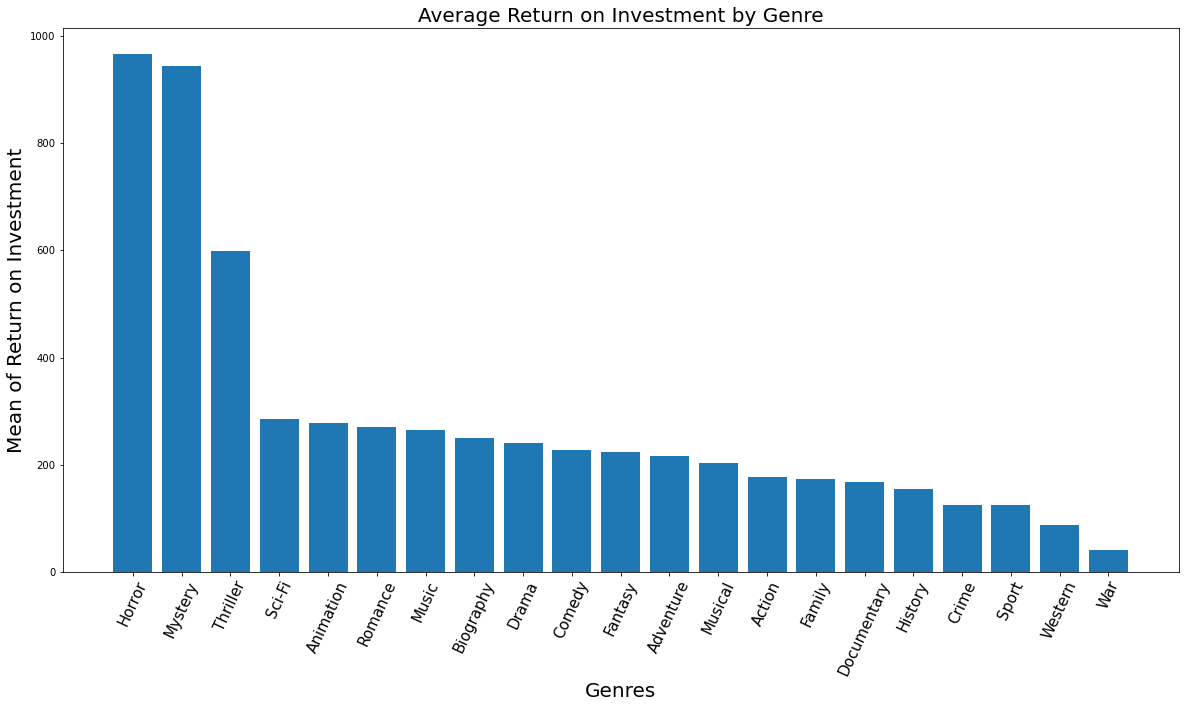

In [55]:
fig, ax = plt.subplots(figsize = (20,10))
x = genreroidf['Genre']
y = genreroidf["ROI mean"]
ax.bar(x,y)
plt.xticks(fontsize = 15, rotation = 65)
ax.set_xlabel("Genres", fontsize = 20)
ax.set_ylabel("Mean of Return on Investment", fontsize = 20)
ax.set_title("Average Return on Investment by Genre", fontsize = 20)

As shown above, this bar graph shows the mean of return on investment for each of the genres. `'Horror'`, `'Mystery'`, and `'Thriller'` appear to yield the highest average return on investment, while `'War'`, `'Western'`, and `'Sports'` yield the lowest. This data visualization can help identify which genres can have a lower risk from the point of view as an investor.

## Size of Market by Genre

Finding the mean return on investment is important in selecting what genres to film, especially as an up-and-coming studio. However, another significant factor to consider is the size of the market - how much total profit was made in each genre. This can help determine where the money lies.

To find the sum of profits of all films in each genre, we used the method `.sum()` on the variables that categorized the data by genre.

In [56]:
imdb_action.profit.sum()

71832227993

Then, we formulated a list containing all of those values.

In [57]:
genre_profit_sum=[imdb_action.profit.sum(),
imdb_adventure.profit.sum(),
imdb_animation.profit.sum(),
imdb_biography.profit.sum(),
imdb_comedy.profit.sum(),
imdb_crime.profit.sum(),
imdb_documentary.profit.sum(),
imdb_drama.profit.sum(),
imdb_family.profit.sum(),
imdb_fantasy.profit.sum(),
imdb_history.profit.sum(),
imdb_horror.profit.sum(),
imdb_music.profit.sum(),
imdb_musical.profit.sum(),
imdb_mystery.profit.sum(),
imdb_romance.profit.sum(),
imdb_sciFi.profit.sum(),
imdb_sport.profit.sum(),
imdb_thriller.profit.sum(),
imdb_war.profit.sum(),
imdb_western.profit.sum()]

The list of unique genres from above and the sum of profits of all films were placed into a new dataframe called `'genretotalprofitdf'`, which organized genres from highest to lowest total profit. Using this dataframe, we formulated a bar graph.

In [58]:
genretotalprofitdf = pd.DataFrame({"Genre":list_of_unique_genres,
                  "Total Profit":genre_profit_sum})
genretotalprofitdf = genretotalprofitdf.sort_values("Total Profit",ascending = False)
genretotalprofitdf

,Genre,Total Profit
1,Adventure,85669810994
0,Action,71832227993
4,Comedy,47874247808
7,Drama,33529711876
16,Sci-Fi,33385429670
2,Animation,28279037149
18,Thriller,21461151555
9,Fantasy,18567395033
8,Family,11945644039
5,Crime,11378317782


Text(0.5, 1.0, 'Size of Market: Total Profit in Each Genre')

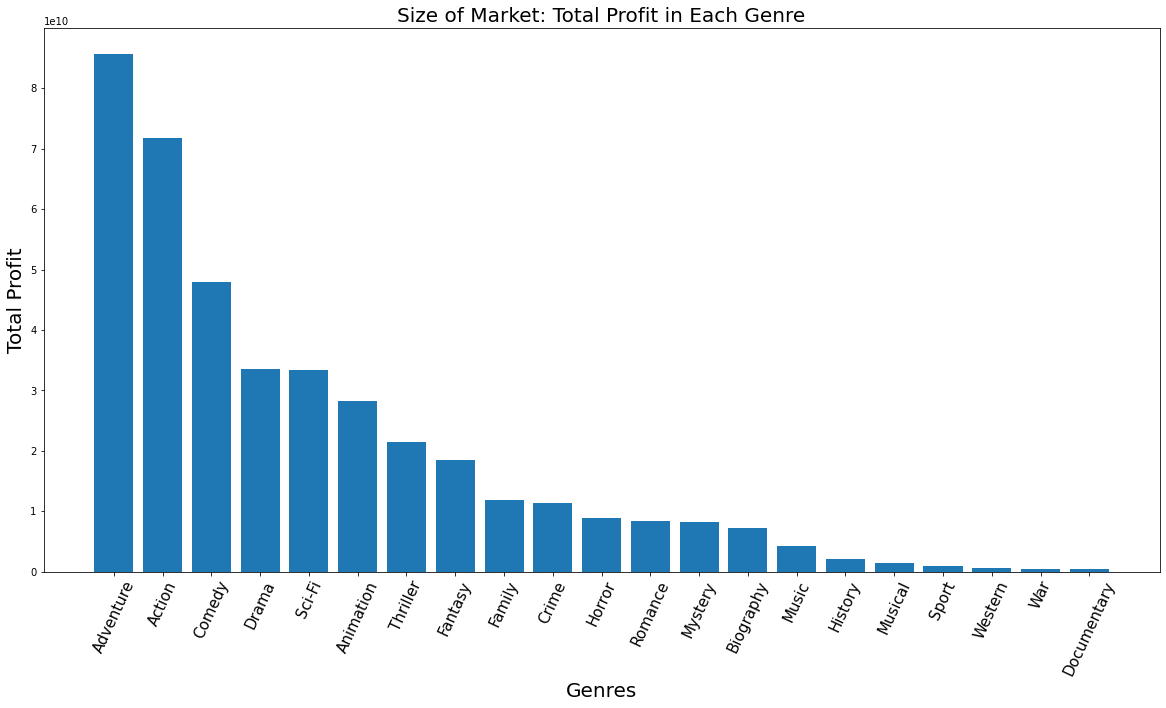

In [59]:
fig, ax = plt.subplots(figsize = (20,10))
x = genretotalprofitdf['Genre']
y = genretotalprofitdf['Total Profit']
ax.bar(x,y)
plt.xticks(fontsize = 15, rotation = 65)
ax.set_xlabel("Genres", fontsize = 20)
ax.set_ylabel("Total Profit", fontsize = 20)
ax.set_title("Size of Market: Total Profit in Each Genre", fontsize = 20)

As this bar graph indicates, `'Action'`, `'Adventure'`, and `'Comedy'` are the biggest markets in terms of profit, while `'War'`, `'Western'`, `'Sport'`, and `'Documentary'` yield the lowest profits. This visualization can provide a general sense of which genres attract the most profit, therefore the size of the market.

## Saturation of the Market

Yes, the total profit of all films in each genre helps us understand the size of the market, but to gain a deeper understanding about the market, we must also consider its saturation. So, how many films are exactly in each of the genres? 

Using the `len()` method, we created a list containing the number of films in each genre.

In [60]:
len(imdb_action)

418

In [61]:
num_per_genres=[len(imdb_action),
len(imdb_adventure),
len(imdb_animation),
len(imdb_biography),
len(imdb_comedy),
len(imdb_crime),
len(imdb_documentary),
len(imdb_drama),
len(imdb_family),
len(imdb_fantasy),
len(imdb_history),
len(imdb_horror),
len(imdb_music),
len(imdb_musical),
len(imdb_mystery),
len(imdb_romance),
len(imdb_sciFi),
len(imdb_sport),
len(imdb_thriller),
len(imdb_war),
len(imdb_western)]

The list of unique genres from above and number of films in each genre were placed into a new dataframe called `genrenumdf`, which organizes genres by their number of films in descending order. This new dataframe was used to formulate a bar graph.

In [62]:
genrenumdf = pd.DataFrame({"Genre":list_of_unique_genres,
                  "Number of Films":num_per_genres})
genrenumdf = genrenumdf.sort_values("Number of Films",ascending = False)
genrenumdf

,Genre,Number of Films
7,Drama,664
4,Comedy,482
0,Action,418
1,Adventure,341
18,Thriller,232
5,Crime,220
15,Romance,177
11,Horror,151
3,Biography,129
16,Sci-Fi,125


Text(0.5, 1.0, 'Saturation of the Film Market by Genre')

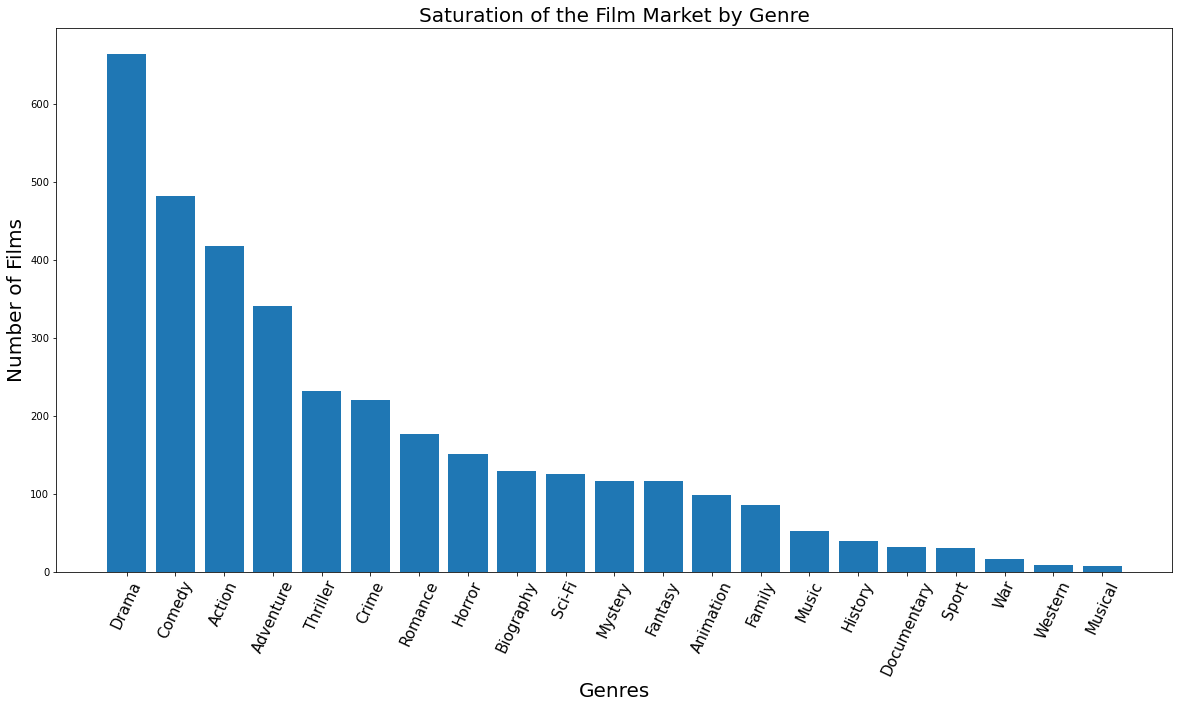

In [63]:
fig, ax = plt.subplots(figsize=(20,10))
x = genrenumdf['Genre']
y = genrenumdf['Number of Films']
ax.bar(x,y)
plt.xticks(fontsize = 15, rotation = 65)
ax.set_xlabel("Genres", fontsize = 20)
ax.set_ylabel('Number of Films', fontsize = 20)
ax.set_title("Saturation of the Film Market by Genre", fontsize = 20)

As this bar graph indicates, `'Drama'`, `'Comedy'`, and `'Action'` have a higher number of films, while `'War'`, `'Western'`, and `'Musical'` have a lower number of films. This visualization not only shows the size of the market based on genre, but also suggests how much competition is in each market.

## Average Profit of a Film in Each Genre

Combining the information on total profit and the number of films in each genre, we can find the average profit of a film in each genre. This allows us to consider which genres could yield the highest profit.

Using the `.mean()` method, we created a list containing the mean profit of films in each genre.

In [64]:
genre_profit_mean=[imdb_action.profit.mean(),
imdb_adventure.profit.mean(),
imdb_animation.profit.mean(),
imdb_biography.profit.mean(),
imdb_comedy.profit.mean(),
imdb_crime.profit.mean(),
imdb_documentary.profit.mean(),
imdb_drama.profit.mean(),
imdb_family.profit.mean(),
imdb_fantasy.profit.mean(),
imdb_history.profit.mean(),
imdb_horror.profit.mean(),
imdb_music.profit.mean(),
imdb_musical.profit.mean(),
imdb_mystery.profit.mean(),
imdb_romance.profit.mean(),
imdb_sciFi.profit.mean(),
imdb_sport.profit.mean(),
imdb_thriller.profit.mean(),
imdb_war.profit.mean(),
imdb_western.profit.mean()]

The list of unique genres from above and the mean profit of films in each genre were placed into a new dataframe called `genreaveprofitdf`, which organizes genres from the highest average profit to the lowest. This new dataframe was then used to formulate a bar graph.

In [65]:
genreaveprofitdf = pd.DataFrame({"Genre":list_of_unique_genres,
                  "Average Profit":genre_profit_mean})
genreaveprofitdf = genreaveprofitdf.sort_values("Average Profit",ascending = False)

Text(0.5, 1.0, 'Average Profit of Film in a Certain Genre')

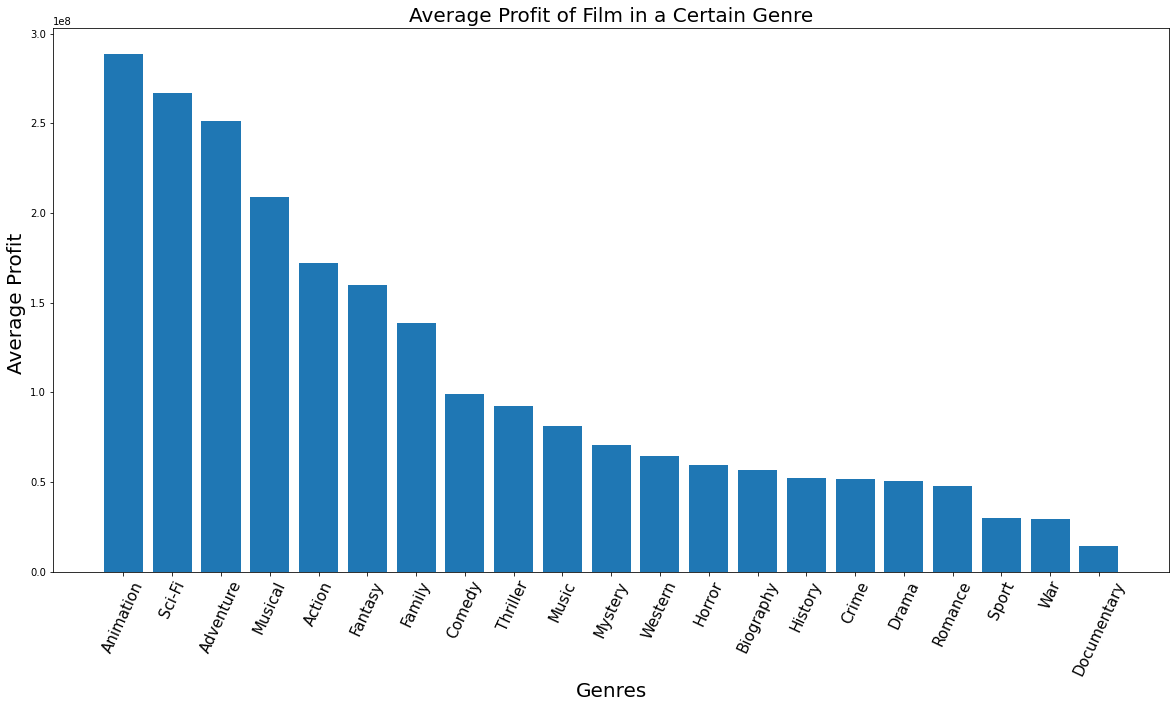

In [66]:
fig, ax = plt.subplots(figsize=(20,10))
x = genreaveprofitdf['Genre']
y = genreaveprofitdf['Average Profit']
ax.bar(x,y)
plt.xticks(fontsize = 15, rotation = 65)
ax.set_xlabel("Genres", fontsize = 20)
ax.set_ylabel('Average Profit ', fontsize = 20)
ax.set_title("Average Profit of Film in a Certain Genre", fontsize = 20)

As this bar graph indicates, films that are `'Animation'`, `'Musical'`, `'Sci-Fi'`, and `'Adventure'` have a high average profit, while films that are `'War'`, `'Sport'`, and `'Documentary'` have a low average profit.

One can gain a deeper understanding about the relationship between genre and profitability by synthesizing the graphs on average ROIs by genre, total profit by genre, number of films in genre, and average profit of film by genre.

The graph on average ROIs by genre indicate that Horror, Mystery, and Thriller have a higher average ROI, suggesting a lower risk in investment, than other genres. However, the markets for the aforementioned genres are actually small compared to more saturated genres with higher attraction of money like Action and Adventure. This means that the pure profit from genres like Horror, Mystery, and Thriller may not be that high, but with lower competition in the genre and a higher average ROI, there may be lower risk and an opportunity to enter a niche market.

On all three metrics, War, Western, Sport, and Documentary genres are likely to not only yield low average profits, but also have low returns on investment. Microsoft Studios should be cautious to involve themselves in these types of genres.

# Goal 2 - Writer and Director Profitablity


## Return on Investment for Directors

The first step was joining our `movie_basics` table to our directors and persons tables and then convert the new SQL table to a Pandas DataFrame.

In [67]:
movie_to_director = """
SELECT mb.primary_title AS title, 
    mb.start_year,
    p.primary_name as director_name,
    p.death_year as dead

    
FROM movie_basics AS mb 
JOIN directors AS d 
    ON d.movie_id = mb.movie_id 
JOIN persons as p
    ON p.person_id= d.person_id


ORDER BY primary_title ASC;"""

In [68]:
directors = pd.read_sql(movie_to_director, conn)
directors = directors.drop_duplicates() 

Next, we merged our DataFrame that connected movies to directors to the `imdb_basics` DataFrame we created as part of our master data set. We perfomed an inner join to keep only the films with the same title that also shared  start years. We joined on two columns in order to avoid false joins where different films have the same title.

In [69]:
d_info_all = pd.merge(left= imdb_basics, right = directors, how = "inner", left_on=["start_year","movie"],\
                  right_on=["start_year","title"])


In [70]:
print("Budget 25th Percentile: ",np.percentile(d_info_all["production_budget"],25))
print("Budget 75th Percentile: ",np.percentile(d_info_all["production_budget"],75))


Budget 25th Percentile:  10000000.0
Budget 75th Percentile:  65000000.0


This data left a lot to be desired, as we had deceased directors, incredibly small budgeted films, and extemely high budgeted films in our data. This was cleaned, eliminating directors that had passed at the time of this data's collection. The data was also constrained to a minimum budget of 10 million dollars and a maximum of 65 million dollars, based on the budget data's 25th and 75th percentiles, respectively. Given the client, this range is ideal as 10 million dollars is an extremely conservative film budget and not much for them to spend. 65 million dollars seems to be a good maximum, as they are establishing a new studio and do should not spend all potential capital on one or two films. These constraints will find a director who is comfortable working in this budget range and returning a profit.

In [71]:

#Filter out the deceased and lower mid budget (btw $10 mil and 65 $mil)
dia = d_info_all[(d_info_all["dead"].isna()) & (d_info_all["production_budget"]>= 10000000) \
                 & (d_info_all["production_budget"]<= 65000000)]

#Give us the column we want
dia2 = dia[["movie", "ROI", "director_name"]]
dia2.sort_values(by = ["ROI"], ascending = False)

,movie,ROI,director_name
1102,The Fault in Our Stars,2459.723617,Josh Boone
503,Halloween,2449.006670,David Gordon Green
111,Black Swan,2448.205462,Darren Aronofsky
1316,La La Land,2031.755815,Damien Chazelle
1459,Annabelle: Creation,1935.899100,David F. Sandberg
...,...,...,...
194,Accidental Love,-99.479092,David O. Russell
770,Freaks of Nature,-99.784976,Robbie Pickering
0,Foodfight!,-99.836209,Lawrence Kasanoff
1250,10 Days in a Madhouse,-99.878200,Timothy Hines


After additional filtering, we now have a DataFrame of all films, their ROI, and their director. As every director has directed films of various budgets, the mean of all ROI was calculated for each director. The results were then listed in decending order and finally graphed on a bar graph.

In [72]:
d_roi = dia2.groupby(['director_name']).mean().sort_values(by=["ROI"], ascending = False)
d_roi


,ROI
director_name,
Josh Boone,2459.723617
Darren Aronofsky,2448.205462
David F. Sandberg,1935.899100
John Krasinski,1867.778200
Adam Robitel,1578.855880
...,...
David Hayter,-99.472483
Robbie Pickering,-99.784976
Lawrence Kasanoff,-99.836209


''

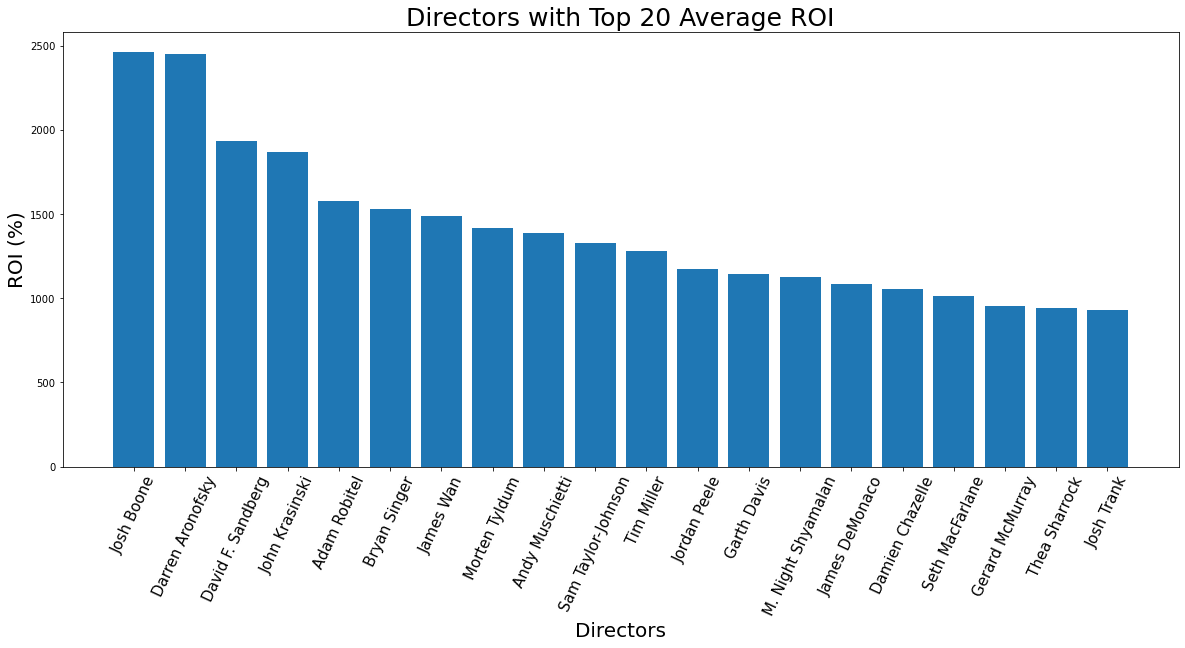

In [73]:
fig, ax = plt.subplots(figsize = (20,8))

d_roi2 = d_roi.head(20)

ax.bar(
    x=d_roi2.index,
    height=d_roi2["ROI"]
)
plt.xticks(fontsize = 15, rotation = 65)
ax.set_title("Directors with Top 20 Average ROI", fontsize = 25)
ax.set_xlabel("Directors", fontsize =20)
ax.set_ylabel("ROI (%)", fontsize =20)
# plt.savefig('director_roi.png')
;

As can be seen, our data filtering has yeilded the client with a list of  directors with the top 20 ROI. It includes notable directors such as Darren Aronofsky, James Wan, Jordan Peele and M. Night Shyamalan. This graph of the top 20 will be presented to the client as well as the full list upon request. However, this is still 20 choices, which may be overwhelming to the client. This will be further filtered after we create a list of writers with the top ROI.

## Return on Investment for Writers

The first step was joining our imdb_basics table to our writers and persons tables and then convert the newly SQL table to a Pandas DataFrame.

In [74]:
movie_to_writer = """
SELECT mb.primary_title AS title,
    mb.start_year,
    w.person_id, 
    p.primary_name as writer_name,
    p.death_year as dead
    
FROM movie_basics AS mb 
JOIN writers AS w 
    ON mb.movie_id = w.movie_id 
JOIN persons as p
    ON p.person_id= w.person_id


ORDER BY primary_title ASC;"""


In [75]:
writers = pd.read_sql(movie_to_writer, conn)
writers = writers.drop_duplicates() 

Next, we merged our DataFrame that connected movies to writers to the `imdb_basics` DataFrame we created as part of our master data set. An inner join was performed in order to keep only the films with the same title that also shared  start years. We joined on two columns in order to avoid false joins where different films have the same title.

In [76]:
w_info_all = pd.merge(left= imdb_basics, right = writers, how = "inner", left_on=["movie", "start_year"],\
                  right_on=["title", "start_year"])


This was cleaned accoring to the guidelines we followed in directors. All deceased writers were eliminated from the new DataFrame and the budget was yet again constrained to the 25th and 75th percentiles (10 million dollars to 65 million dollars).

In [77]:


#Filter out the dead and lower - mid budget (between $10 mil and $65 mil)
wia = w_info_all[(w_info_all["dead"].isna()) & (w_info_all["production_budget"]>= 10000000) \
                 & (w_info_all["production_budget"]<= 65000000)]
#Give us the column we want
wia2 = wia[["movie", "ROI", "writer_name"]]
wia2.sort_values(by = ["ROI"], ascending = False)

,movie,ROI,writer_name
2641,The Fault in Our Stars,2459.723617,John Green
2642,The Fault in Our Stars,2459.723617,Michael H. Weber
2643,The Fault in Our Stars,2459.723617,Scott Neustadter
1276,Halloween,2449.006670,David Gordon Green
1278,Halloween,2449.006670,Danny McBride
...,...,...,...
2,Foodfight!,-99.836209,Lawrence Kasanoff
0,Foodfight!,-99.836209,Sean Catherine Derek
2966,10 Days in a Madhouse,-99.878200,Timothy Hines
2589,Broken Horses,-99.976860,Vidhu Vinod Chopra


After additional filtering, we now have a DataFrame of all films, their ROI, and their writers. The mean of each writers ROIs were calculated. The results were then listed in decending order and graphed on a bar graph.

In [78]:
w_roi = wia2.groupby(['writer_name']).mean().sort_values(by=["ROI"], ascending = False)
w_roi 

,ROI
writer_name,
David Gordon Green,2449.006670
Jeff Fradley,2449.006670
Andres Heinz,2448.205462
Mark Heyman,2448.205462
Damien Chazelle,2031.755815
...,...
Lawrence Kasanoff,-99.836209
Sean Catherine Derek,-99.836209
Timothy Hines,-99.878200


''

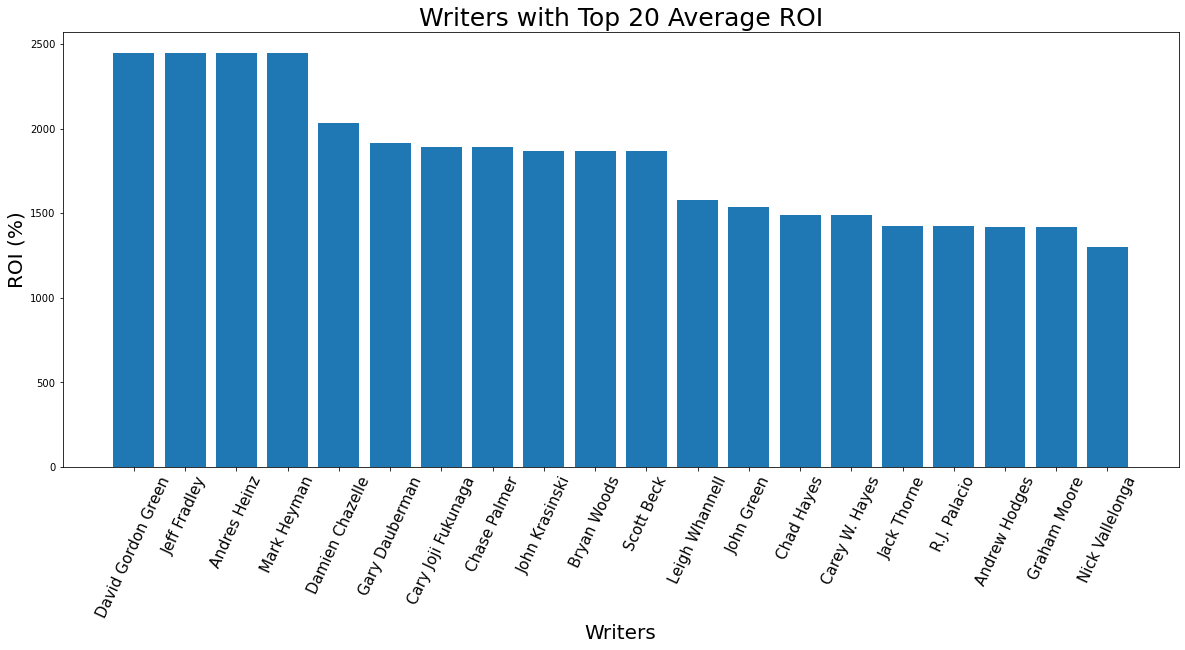

In [79]:
fig, ax = plt.subplots(figsize = (20,8))

w_roi2 = w_roi.head(20)  #

ax.bar(
    x=w_roi2.index,
    height=w_roi2["ROI"]
)
plt.xticks(fontsize = 15, rotation = 65)
ax.set_title("Writers with Top 20 Average ROI", fontsize = 25)
ax.set_xlabel("Writers", fontsize =20)
ax.set_ylabel("ROI (%)", fontsize =20)
# plt.savefig('writer_roi.png')
;

As can be seen, our data filtering has yeilded the clinet with a list of writers with the top 20 ROIs. Notable individuals on the list include: David Gordon Green, Cary Fukunaga, and John Krasinski. This graph of the top 20 will be presented to the client as well as the full list upon request. We still have many writers to choose from and we need to match them to a director. 


However, it would be much simpler to get a writer who is also a director, to save the trouble of having to mach the two roles. It also introduces potential cost savings in streamlining production, as you would only need pay the director slightly more to do the work of two people, rather than paying two seperate people full salaries.

# Who can both direct and write and still deliver the highest return on investment?


First we will join our director and writer DataFrames.

In [80]:
d_w_combo = pd.merge(left= dia, right = wia, how = "inner", left_on=["movie", "start_year"],\
                  right_on=["title", "start_year"])

Then we will filter our DataFrame to only rows where the writer and director are the same and return a list of mean ROI by director in descending order.

In [81]:
d_w_combo_fil = d_w_combo[d_w_combo["director_name"]==d_w_combo["writer_name"]]
dwc =  d_w_combo_fil[["movie_x", "ROI_x", "writer_name", "director_name"]]
dirwr = dwc.groupby(['writer_name']).mean().sort_values(by=["ROI_x"], ascending = False)
dirwr.head()

,ROI_x
writer_name,
David Gordon Green,2449.006670
Damien Chazelle,2031.755815
John Krasinski,1867.778200
Jordan Peele,1171.051550
M. Night Shyamalan,1126.517525


This list can then be turned into a bar graph, showing the director/writers that yield the highest return on investment for mid-tier budgeted films. 

''

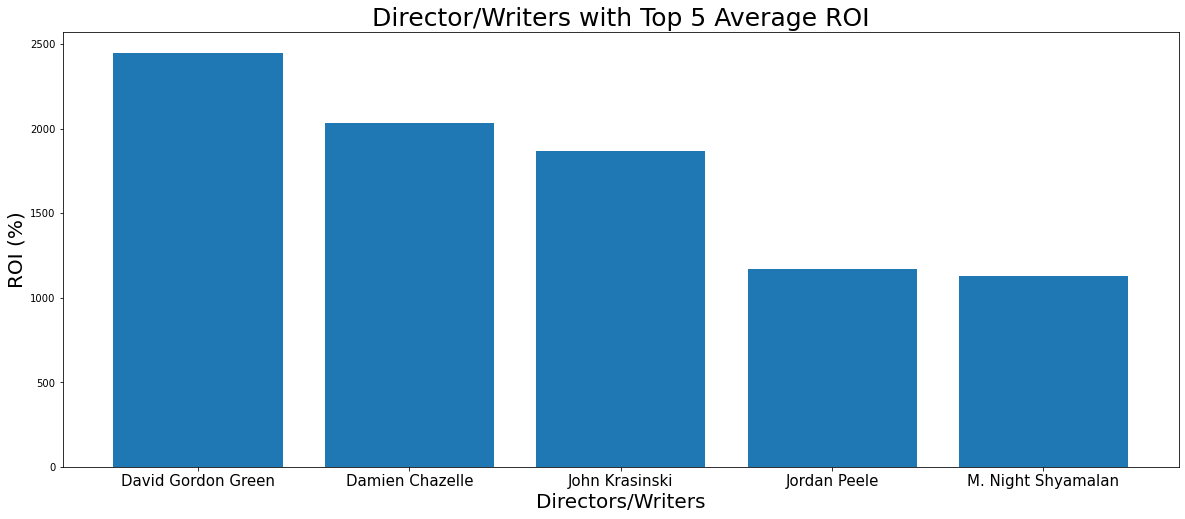

In [82]:
fig, ax = plt.subplots(figsize = (20,8))

top_5 = dirwr.head()

ax.bar(
    x=top_5.index,
    height=top_5["ROI_x"]
)
plt.xticks(fontsize = 15, rotation = 0)
ax.set_title("Director/Writers with Top 5 Average ROI", fontsize = 25)
ax.set_xlabel("Directors/Writers", fontsize =20)
ax.set_ylabel("ROI (%)", fontsize =20)
# plt.savefig('director_writer_roi.png')
;

In [83]:
col_want = d_w_combo_fil [["genres_x","movie_x","director_name","writer_name"]]
ddg = col_want[(col_want["director_name"] == "David Gordon Green") |(col_want["writer_name"] == "David Gordon Green")]
ddg_genre = ddg["genres_x"].map(lambda x: x.split(","))
ddg_genre

888    [Horror, Thriller]
Name: genres_x, dtype: object

### From this data, we would recomend that our client hires the  writer/director with the highest average return on investment, David Gordon Green. The primary genres he works in are horror and thrillers.

## Goal 3 - Finding the perfect time to release

## ROI per month

Here I dropped the rows with no genres so there are no errors when I eventually code, while also filtering out the years that I needed which were 2012 to 2019 so any thing before doesn't contradict my graph fidnings. 

In [85]:
imdb_basics=imdb_basics.dropna(subset=['genres'])

In [84]:
[imdb_basics['start_year']>=2012] #Only using dates from to 2012 and up

[0        True
 1        True
 2        True
 3        True
 4       False
         ...  
 1417     True
 1418     True
 1419     True
 1420     True
 1421     True
 Name: start_year, Length: 1365, dtype: bool]

In [86]:
imdb_basics.info() #info check

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 0 to 1421
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           1365 non-null   object 
 1   primary_title      1365 non-null   object 
 2   original_title     1365 non-null   object 
 3   start_year         1365 non-null   int64  
 4   runtime_minutes    1359 non-null   float64
 5   genres             1365 non-null   object 
 6   id                 1365 non-null   int64  
 7   release_date       1365 non-null   object 
 8   movie              1365 non-null   object 
 9   production_budget  1365 non-null   int64  
 10  domestic_gross     1365 non-null   int64  
 11  worldwide_gross    1365 non-null   int64  
 12  ROI                1365 non-null   float64
 13  profit             1365 non-null   int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 160.0+ KB


## Making a new column for month

I added a new column to the data set because in order to graph which season would be best I needed the month so I grabbed from the release date column and only took the abbreviated month using lambda function which worked out great for me as you can see from the column

In [87]:
imdb_basics["month"] = imdb_basics["release_date"].map(lambda x: str(x[:4])) # Using lambda to only grab abbreviated the month
#to make the new month column

In [88]:
imdb_basics.head() #checking to see if column is there

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,profit,month
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",26,"Dec 31, 2012",Foodfight!,45000000,0,73706,-99.836209,-44926294,Dec
1,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000,58236838,187861183,106.440860,96861183,Dec
2,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",67,"Sep 19, 2014",A Walk Among the Tombstones,28000000,26017685,62108587,121.816382,34108587,Sep
3,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,666.909239,1433854864,Jun
4,tt0376136,The Rum Diary,The Rum Diary,2011,119.0,"Comedy,Drama",16,"Oct 28, 2011",The Rum Diary,45000000,13109815,21544732,-52.122818,-23455268,Oct


In [89]:
imdb_basics['month'].value_counts() #checking for unique values

Oct     152
Dec     143
Nov     137
Sep     134
Jul     118
Mar     117
Aug     115
Jun     112
May      93
Apr      92
Feb      86
Jan      66
Name: month, dtype: int64

## Finding ROI for month of the year

Here I had to make a new variable and get every month from the column with the ROI column and find the average using the mean function and it'll give me the ROI for each month

In [90]:
roi_by_month = [imdb_basics[imdb_basics['month'] =='Jan ']['ROI'].mean(), imdb_basics[imdb_basics['month'] == 'Feb ']['ROI'].mean(), imdb_basics[imdb_basics['month'] == 'Mar ']['ROI'].mean(),
                imdb_basics[imdb_basics['month'] == 'Apr ']['ROI'].mean(), imdb_basics[imdb_basics['month'] == 'May ']['ROI'].mean(), imdb_basics[imdb_basics['month'] == 'Jun ']['ROI'].mean(),
                imdb_basics[imdb_basics['month'] == 'Jul ']['ROI'].mean(), imdb_basics[imdb_basics['month'] == 'Aug ']['ROI'].mean(), imdb_basics[imdb_basics['month'] == 'Sep ']['ROI'].mean(),
                imdb_basics[imdb_basics['month'] == 'Oct ']['ROI'].mean(), imdb_basics[imdb_basics['month'] == 'Nov ']['ROI'].mean(), imdb_basics[imdb_basics['month'] == 'Dec ']['ROI'].mean()]
print(roi_by_month) 
#Taking the Roi of each month and using mean to get the average

[426.19375944955345, 304.70692039806465, 197.71268888440835, 220.8353755625571, 246.94284934828954, 288.5300447420565, 709.0608938452683, 229.2139360763168, 191.25609426139943, 345.0304508119032, 246.731342550196, 210.65810606503175]


In [91]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] #new list for bar graph

In [92]:
imdb_basics.info() #another check!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 0 to 1421
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           1365 non-null   object 
 1   primary_title      1365 non-null   object 
 2   original_title     1365 non-null   object 
 3   start_year         1365 non-null   int64  
 4   runtime_minutes    1359 non-null   float64
 5   genres             1365 non-null   object 
 6   id                 1365 non-null   int64  
 7   release_date       1365 non-null   object 
 8   movie              1365 non-null   object 
 9   production_budget  1365 non-null   int64  
 10  domestic_gross     1365 non-null   int64  
 11  worldwide_gross    1365 non-null   int64  
 12  ROI                1365 non-null   float64
 13  profit             1365 non-null   int64  
 14  month              1365 non-null   object 
dtypes: float64(2), int64(6), object(7)
memory usage: 170.6+ KB


## The Graph finally

I used a bar chart to calculate the relationship between them and found that july is the best time to release a movie which is in the season of summer!

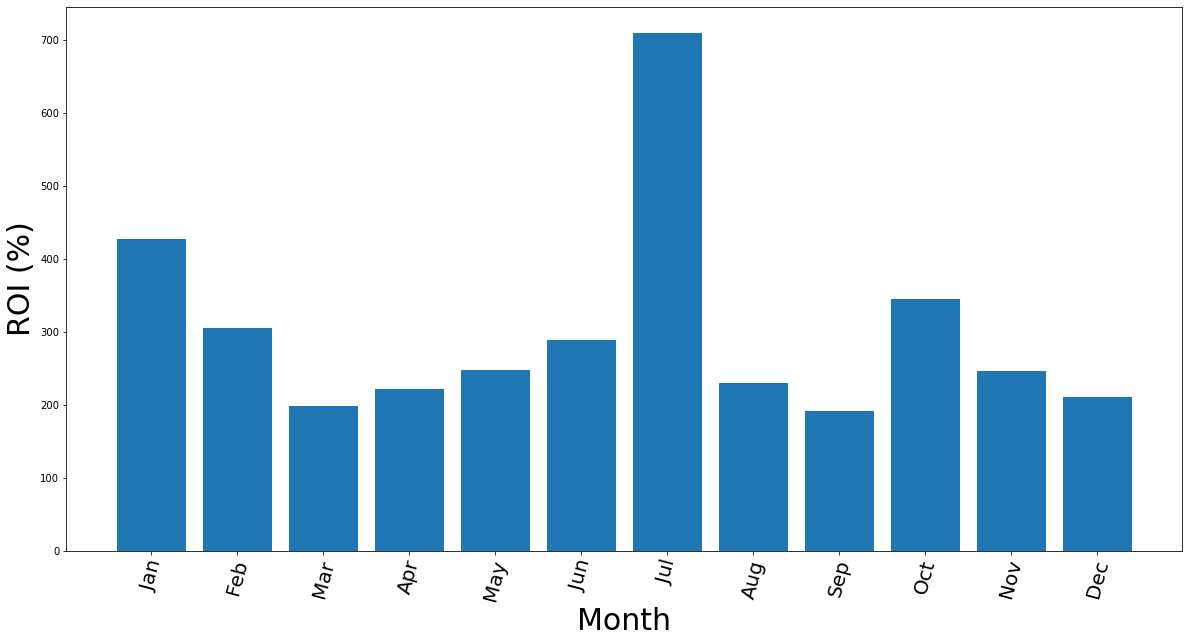

In [93]:
fig, ax = plt.subplots(figsize = (20,10))
x = months
y = roi_by_month
ax.bar(x,y)
plt.xticks(fontsize = 20, rotation = 75)
ax.set_xlabel("Month", fontsize=30)
ax.set_ylabel("ROI (%)", fontsize=30);
       #Graphing to see the connection between month ROI to see 
# which is the best month to release a movie 

# Appendix: 

#### Is critical reception correlated to ROI? Worldwide Gross? Domestic Gross?

In [126]:
mb_to_ratings = """
SELECT mb.primary_title AS title,
    mb.start_year,
    rt.averagerating,
    rt.numvotes
    
FROM movie_basics AS mb 
JOIN movie_ratings AS rt
    ON mb.movie_id = rt.movie_id 

ORDER BY rt.numvotes DESC;"""

movie_ratings = pd.read_sql(mb_to_ratings, conn)

In [127]:
crit_rate = movie_ratings[(movie_ratings["numvotes"]>= 50000)]
#Preventing low rating numbers from affecting results
    
    
crit_all = pd.merge(left= imdb_basics, right = crit_rate, how = "inner", left_on=["movie", "start_year"],\
                  right_on=["title", "start_year"])

crit_use_unsort = crit_all[["title","production_budget","domestic_gross", "worldwide_gross", "ROI", \
                            "averagerating", "numvotes" ]]

crit_use_unsort2=crit_use_unsort[(crit_use_unsort["production_budget"] >= 10000000) \
                                 & (crit_use_unsort["production_budget"] <= 65000000)] 
#Filtering data further by only looking at movies with production budgets of $10 million or more

crit_use = crit_use_unsort2.sort_values(by = ["averagerating"], ascending = False)
crit_use

,title,production_budget,domestic_gross,worldwide_gross,ROI,averagerating,numvotes
759,Baahubali 2: The Conclusion,30000000,18985794,263502914,778.343047,8.3,65656
792,Green Book,23000000,85080171,322034439,1300.149735,8.3,204972
669,Room,13000000,14677674,36262783,178.944485,8.2,316791
764,"Three Billboards Outside Ebbing, Missouri",12000000,54513740,160191915,1234.932625,8.2,344047
209,Warrior,25000000,13657115,24215385,-3.138460,8.2,403755
...,...,...,...,...,...,...,...
348,LOL,11000000,0,10431506,-5.168127,4.4,51424
332,Skyline,10000000,21416355,68264973,582.649730,4.4,83710
230,Movie 43,10000000,8840453,31164747,211.647470,4.3,92980
579,Fifty Shades of Grey,40000000,166167230,570998101,1327.495253,4.1,279126


''

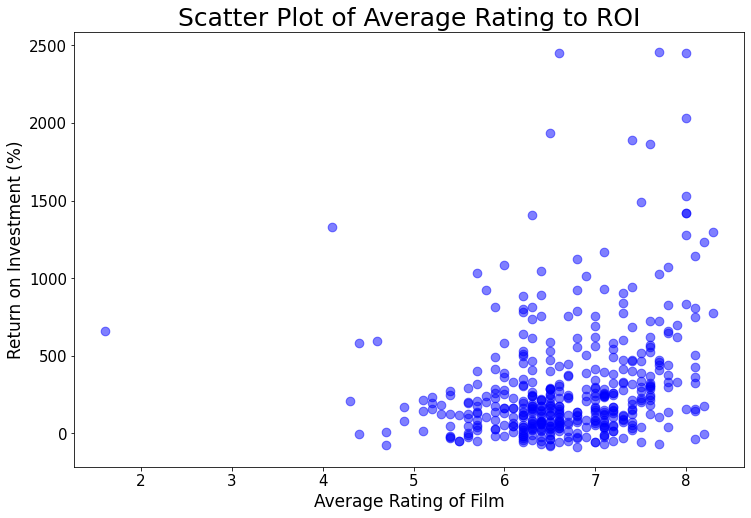

In [128]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))

rate = crit_use["averagerating"]
wwgross = crit_use["worldwide_gross"]
dgross = crit_use["domestic_gross"]
roi = crit_use["ROI"]


ax.scatter(x = rate, y =roi,  s = 75, color = "blue", alpha = .5)



plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_title("Scatter Plot of Average Rating to ROI", fontsize = 25)
ax.set_xlabel("Average Rating of Film", fontsize =17)
ax.set_ylabel("Return on Investment (%)", fontsize =17)
# plt.savefig('rate_avg_to_gross')
;



In [129]:
correlation_roi = rate.corr(roi)
correlation_ww = rate.corr(wwgross)
correlation_d = rate.corr(dgross)

print("Person Correslation between average critical rating and ROI is: ", correlation_roi)
print("Person Correslation between average critical rating and worldwide gross is: ", correlation_ww)
print("Person Correslation between average critical rating and domestic gross is: ", correlation_d)


Person Correslation between average critical rating and ROI is:  0.25645427178907193
Person Correslation between average critical rating and worldwide gross is:  0.1967788913569292
Person Correslation between average critical rating and domestic gross is:  0.21496797446982432


#### So there is a positve correlation between critcal rating and ROI/Worldwide gross/domestic gross but its not a high/significant result.

# Future
### Look into the ROI for actors/actresses to help narrow down casting
### Narrow down writers by region/language to get even more relevant results
### Figure out if runtime affects profitability 
### Track if a directors ROI can be predicted through modeling (ex. If certain director is given budget X, the ROI will most likely be in Y range
### Create a program that you can enter one or more of several variables, and will output ideal director/writer/time of release/etc. based on input

### Gather/find new information reguarding the marketing budget and its relationship to total gross and ROI